# Step 0: Get reference position values

- Assume all the photos were taken with similar conditions
- Skewers and tapes are always in the same position
- This helps to keep further analyses consistent
- Find the location of the skewer and the tape
- Compute the best linear approximation for each of the 5 skewers
- Later collect all computations and remove outliers (values too far away from the median) to correct for artifacts
    - Sometimes, the tape would fall off the skewer

In [26]:
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal

import os
import pandas as pd

# Define structure

- `src`: Directory with all the images.
    - one subdirectory per repetition
    - Assumed that subdirectory names have structure `4pm Inc Rep 7`
- `dst`: Where results will be stored
- Create an array with metadata information for each repetion
- `erode` is an array with length equal to number of cuscutas per repetition

In [14]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)


w = 5
its = 15
pad = its+10
fs = 20

mind = 50
buffx = 0
buffX = 1450
buffy = 200

src = '../raw/'
dst = '../reference/'
imgsets = sorted(glob(src + '*/'))

# Fix one folder

- Say `jdx = 12` corresponding to repetion 7 @ 4pm
- Load all the image filenames
- Extract their number tag
- Sort the tags accordingly

In [3]:
def get_repetition_metadata(imgsetname):
    filenames = glob(imgsetname + '*')
    reptime,_,_,repnum = imgsetname.split('/')[-2].split(' ')
    
    nums = np.zeros(len(filenames), dtype=int) - 1
    for i in range(len(nums)):
        num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('(')[1][:-1]
        num = int(num)
        nums[i] = num
    nums = np.argsort(nums)

    return filenames, reptime, repnum, nums

In [6]:
jdx = 12 # 4pm 1
filenames, reptime, repnum, nums = get_repetition_metadata(imgsets[jdx])
print(reptime, repnum)

4pm 7


# Fix one image file

- Load the image and just consider the green band
- Estimate the x-location of all the skewers
    - Consider the median red value of each x value (excluding the first 300 pixels, as they may be black)
    - Find all the distinct minima
- Once the center of the skewer is found, create a slice centered on it
    - Slice of width `2*buffy` and height `buffX - buffx`

In [7]:
idx = 121
filename = filenames[nums[idx]]
numidx = int(os.path.splitext(os.path.split(filename)[1])[0].split('(')[1][:-1])
print(jdx, filename, numidx, sep='\t')
raw = cv2.imread(filename)
graw = raw[:,:,1]

12	../raw/4pm Inc Rep 7/4pm Inc Rep 7 (122).JPG	122


In [8]:
def get_peaks_slices(raw, buffx=0, buffX=1450, buffy=50, nsamples=5):
    
    medians = np.median(raw[:,:,0], axis=0)[300: ]
    peaks, foo = signal.find_peaks(255 - medians, distance=300, height=140, prominence=50)
    peaks += 300
    if len(peaks) < 6:
        peaks = np.hstack((peaks, [raw.shape[1]]))
    stickss = [np.s_[buffx:buffX+buffx, peaks[i]-buffy:peaks[i]+buffy] for i in range(nsamples)]

    return peaks, stickss

In [19]:
peaks, stick = get_peaks_slices(raw, buffx, buffX, buffy)
print('Peaks:\t',peaks)
stick

Peaks:	 [ 593 1294 2068 2925 3759 4679]


[(slice(0, 2475, None), slice(393, 793, None)),
 (slice(0, 2475, None), slice(1094, 1494, None)),
 (slice(0, 2475, None), slice(1868, 2268, None)),
 (slice(0, 2475, None), slice(2725, 3125, None)),
 (slice(0, 2475, None), slice(3559, 3959, None))]

# Fix one skewer

- Get the 75th quantile of green intensity around the skewer
- Only consider a slice of thickness `2*w`
- **Reconstruct the skewer:** we need to remove any cuscuta that might be in front of it
    - Discard everything higher than that 75th quantile
    - Remove salt-pepper noise with a median filter
    - Get the boundary
    - Dilate the boundary with a `struc2` structure by `its` iterations
    - Fill the boundary
    - Erode it by `its//2` iterations with the same `struc2` structure
    - Save the reconstructed skewere in the `erode` list
- **Get the tape y position**
    - Simply find where the skewer has minimum width
    - Ignore the first 400 pixels
- **Approximate the skewer with a 1-D polynomial (a line)**

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/cuscuta/figs/skewer_detection_approximation.jpg)

In [20]:
horz = np.array([[0,0,0],[1,1,1],[0,0,0]], dtype=bool)
PAD = 1
def approx_skewer(graw, peak, buffx=0, buffX=1450, buffy=50, w=5, struc2=ndimage.generate_binary_structure(2,2), its=15, pad=25):
    
    q75 = np.quantile(graw[ buffx:, peak-w:peak+w], 0.75)
    q75 = np.min([90, q75])
    
    rmask = graw[stick[i]] < q75
    rmask = ndimage.median_filter(rmask, 11)
    rmask = np.pad(rmask, pad)
    
    bound = ndimage.convolve(rmask, boundary, mode='constant', cval=0)
    bound = ndimage.binary_dilation(bound, structure = struc2, iterations=its)
    
    fill = ndimage.binary_fill_holes(bound)
    erod = ndimage.binary_erosion(fill, structure = struc2, iterations=its//2, border_value=1)
    erode = erod[pad:-pad, pad:-pad]
    
    sumvals = np.sum(erode[400:buffX], axis = 1)
    tape = np.argmin(sumvals) + 400

    cdt = ndimage.distance_transform_cdt(erod, metric=horz)
    cdt = cdt[pad:-pad, pad:-pad]
    medial = np.argmax(cdt, axis=1)
    
    mask = medial > 0
    coef = P.polyfit(np.arange(len(medial))[mask], medial[mask], 1,full=False)
    
    return coef, tape, erode

# Put everything in a loop and plot

In [22]:
coefs = np.zeros((5,2))
tapes = np.zeros(len(coefs), dtype=int)
erode = [None for i in range(len(coefs))]

for i in range(len(coefs)):
    coefs[i], tapes[i], erode[i] = approx_skewer(graw, peaks[i], buffX=buffX)

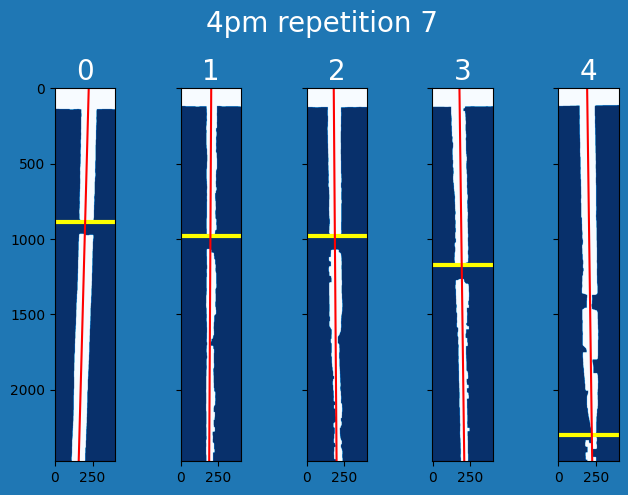

In [23]:
fig, ax = plt.subplots(1,len(stick),figsize=(7,5), sharex=True, sharey=True, facecolor='tab:blue')
ax = np.atleast_1d(ax).ravel()

for i in range(len(stick)):

    ax[i].imshow(erode[i], vmin=0, cmap='Blues_r')
    ax[i].set_title(i, fontsize=fs, color='w')
    ax[i].axhline(tapes[i], c='yellow', lw=3, zorder=2)

    b0 = peaks[i] + coefs[i,0] - buffy
    line = b0 + coefs[i,1]*(np.arange(len(raw)) - buffx)
    
    ax[i].plot((line - b0 + coefs[i,0])[:buffX], np.arange(buffX), c='r')

fig.suptitle('{} repetition {}'.format(reptime, repnum), fontsize=fs, color='w')
fig.tight_layout();

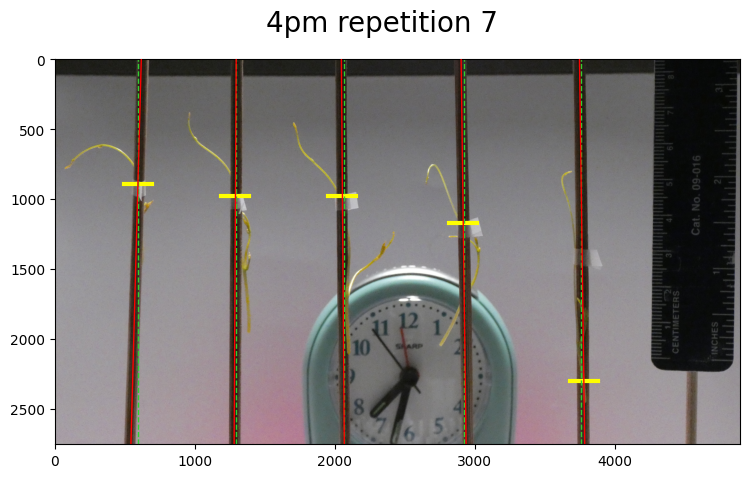

In [24]:
fig, ax = plt.subplots(1,1,figsize=(12,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
ax[0].imshow(raw[:,:,::-1])
for i in range(len(coefs)):
    b0 = peaks[i] + coefs[i,0] - buffy
    line = b0 + coefs[i,1]*(np.arange(len(raw)) - buffx)
    
    ax[0].plot([line[tapes[i]]-100, line[tapes[i]]+100], [buffx+tapes[i], buffx+tapes[i]], c='yellow', lw=3)
    ax[0].axvline(peaks[i], c='limegreen', ls='--', lw=1, zorder=2)
    ax[0].plot(line, range(len(raw)), c='red', lw=1, zorder=3)
        
fig.suptitle('{} repetition {}'.format(reptime, repnum), fontsize=fs);

# Generate metadata

- All you really need
- The above is just a fleshed out version

In [71]:
dst = '../reference/'
nsamples = 5
jdx = 0
filenames, reptime, repnum, nums = get_repetition_metadata(imgsets[jdx])

dst = dst + '{}_rep{}/'.format(reptime, repnum)
if not os.path.isdir(dst):
    os.mkdir(dst)
    
for idx in range(len(nums)):
    filename = filenames[nums[idx]]
    numidx = int(os.path.splitext(os.path.split(filename)[1])[0].split('(')[1][:-1])
    fname = dst + 'metapx_{}_rep{}_{:04d}.csv'.format(reptime, repnum, numidx)

    if not os.path.isfile(fname):
    
        raw = cv2.imread(filename)
        
        peaks, stick = get_peaks_slices(raw, buffx, buffX, buffy)
        
        coefs = np.zeros((nsamples,2))
        tapes = np.zeros(len(coefs), dtype=int)
        for i in range(len(coefs)):
            coefs[i], tapes[i], _ = approx_skewer(raw[:,:,1], peaks[i])
            
        np.savetxt(fname, np.hstack((peaks[:nsamples], tapes)), fmt='%d', delimiter=',', newline=',')
        fname = dst + 'metacf_{}_rep{}_{:04d}.csv'.format(reptime, repnum, numidx)
        np.savetxt(fname, np.ravel(coefs, order='F'), fmt='%.5e', delimiter=',', newline=',')

# Wrangle metadata

- Get everything in a single, nice file
- Identify outliers

In [30]:
def read_files(filenames):
    meta = np.zeros((len(filenames), 2*nsamples))
    for i in range(len(meta)):
        meta[i] = pd.read_csv(filenames[i], header=None).values.squeeze()[:-1]
    return meta

def correct_outliers(meta, tolpx=75):
    quantiles = np.quantile(meta, [.25, .75], axis=0)
    iqr = np.diff(quantiles, axis=0).squeeze()
    for i in range(meta.shape[1]):
        v = quantiles[0,i] - 1.5*iqr[i]
        mask = meta[:, i] < v
        meta[mask, i] = v

        v = quantiles[1,i] + 1.5*iqr[i]
        mask = meta[:, i] > v
        meta[mask, i] = v
    return meta

def correct_outliers(meta, tolpx=75):
    medians = np.median(meta, axis=0)
    mask = np.abs(meta - medians) > tolpx
    for i in range(mask.shape[1]):
        meta[mask[:,i], i] = medians[i]
    return meta

In [31]:
nsamples = 5
src = '../reference/'
reptime = '4pm'
repnum = '7'

src += '{}_rep{}/'.format(reptime, repnum)

filenames = sorted(glob(src + 'metapx*.csv'))
metapx = read_files(filenames)

filenames = sorted(glob(src + 'metacf*.csv'))
metacf = read_files(filenames)

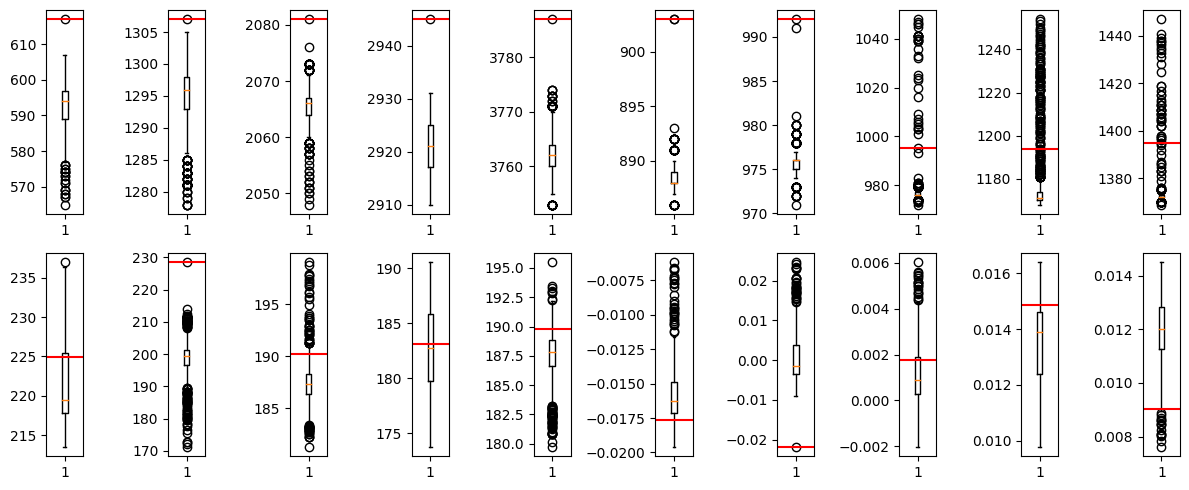

In [32]:
idx = 0

fig, ax = plt.subplots(2,2*nsamples,figsize=(12,5))
for i in range(nsamples*2):
    ax[0,i].boxplot(metapx[:,i])
    ax[1,i].boxplot(metacf[:,i])
    ax[0,i].axhline(metapx[idx,i], c='r')
    ax[1,i].axhline(metacf[idx,i], c='r')
fig.tight_layout()

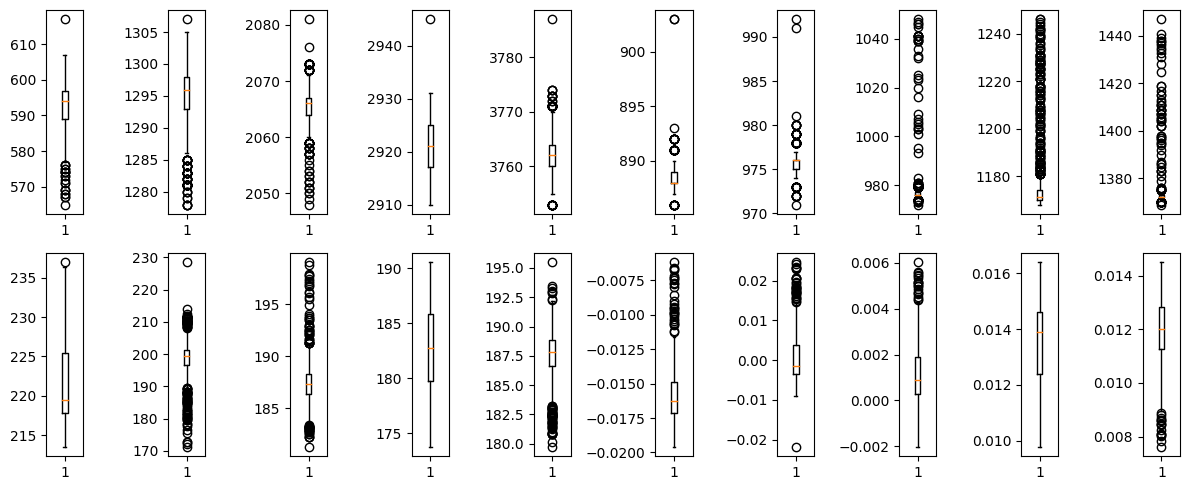

In [33]:
metapx = correct_outliers(metapx).astype(int)
metacf = correct_outliers(metacf)

fig, ax = plt.subplots(2,2*nsamples,figsize=(12,5))
for i in range(nsamples*2):
    ax[0,i].boxplot(metapx[:,i])
    ax[1,i].boxplot(metacf[:,i])
fig.tight_layout()

In [36]:
meta = pd.DataFrame()
meta['numidx'] = [int(os.path.splitext(filenames[i])[0].split('_')[-1]) for i in range(len(filenames))]

pos = pd.DataFrame(metapx, columns=['peaks_{}'.format(i) for i in range(nsamples)] + ['tapes_{}'.format(i) for i in range(nsamples)])
coef = pd.DataFrame(metacf,columns=['coef0_{}'.format(i) for i in range(nsamples)] + ['coef1_{}'.format(i) for i in range(nsamples)])
meta = meta.join(pos).join(coef)
meta.head()

,numidx,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,...,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
0,1,617,1307,2081,2945,3787,903,992,995,1194,...,224.909,228.658,190.235,183.072,189.759,-0.017661,-0.021867,0.001748,0.014864,0.009036
1,2,597,1291,2069,2931,3769,893,980,983,1181,...,227.745,200.906,186.711,181.974,192.363,-0.017171,0.005466,0.004167,0.015038,0.008791
2,3,573,1296,2061,2927,3762,903,991,993,1221,...,236.140,188.049,187.639,183.790,190.927,-0.007194,0.008313,0.003852,0.011888,0.011083
3,4,583,1296,2064,2930,3766,890,978,979,1174,...,232.565,181.112,185.558,180.871,187.369,-0.011769,0.015637,0.003632,0.012464,0.010194
4,5,604,1297,2065,2925,3761,891,976,979,1176,...,218.414,201.373,184.803,182.785,189.889,-0.017212,-0.003465,0.003809,0.014073,0.009635


In [38]:
fname = '../reference/reference_positions_{}_rep{}.csv'.format(reptime, repnum)
print(fname)
meta.to_csv(fname, index=False)

../reference/reference_positions_4pm_rep7.csv


# Scratch

In [81]:
print(img.shape, initd.shape)

(400, 1475) (401, 1476)


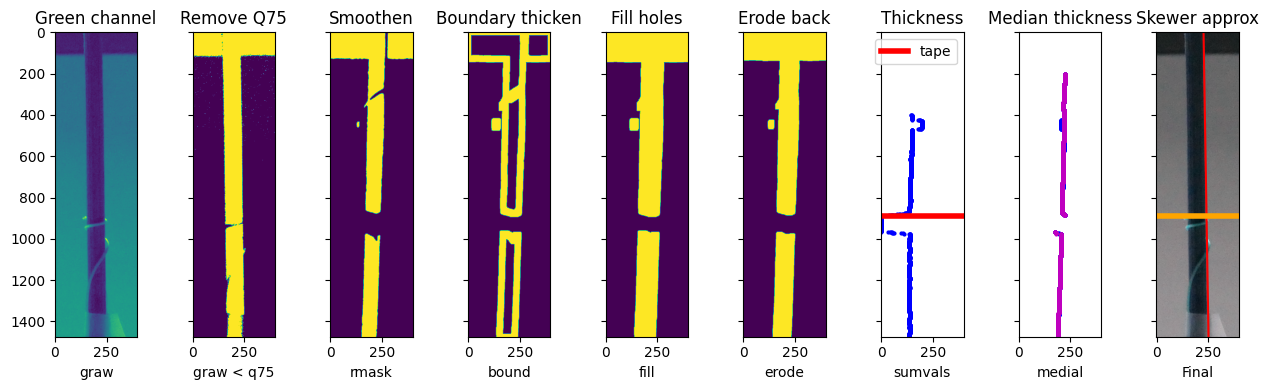

In [114]:
fig, ax = plt.subplots(1, 9, figsize=(13,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

title = ['Green channel', 'Remove Q75', 'Smoothen', 'Boundary thicken', 'Fill holes', 'Erode back']
xlabs = ['graw', 'graw < q75', 'rmask', 'bound', 'fill', 'erode']
for j,img in enumerate([ graw[stick[i]], graw[stick[i]] < q75, rmask[pad:-pad, pad:-pad], bound[pad:-pad, pad:-pad], fill[pad:-pad, pad:-pad], erode[0] ]):
    ax[j].imshow(img)
    ax[j].set_title(title[j])
    ax[j].set_xlabel(xlabs[j])

j += 1
ax[j].scatter(sumvals/np.max(sumvals)*buffy, np.arange(400,buffX,1), s=4, c='b')
ax[j].axhline(tape, c='red', label='tape', lw=4)
ax[j].legend(fontsize=10)
ax[j].set_title('Thickness')
ax[j].set_xlabel('sumvals')

j += 1
ax[j].scatter(medial[mask], xmvals[mask], s=4, c='b')
ax[j].scatter(np.argmax(cdt, axis=1)[mask], xmvals[mask], s=4, c='m')
ax[j].set_title('Median thickness')
ax[j].set_xlabel('medial')

j += 1
ax[j].imshow(raw[stick[i]])
ax[j].plot((line - b0 + coef[0])[:buffX], np.arange(buffX), c='r')
ax[j].set_title('Skewer approx')
ax[j].set_xlabel('Final')
ax[j].axhline(tape, c='orange', label='tape', lw=4)

for j in range(len(ax)):
    ax[j].margins(0)
    ax[j].set_aspect('equal')
fig.tight_layout()

#plt.savefig('skewer_detection_approximation.jpg', dpi = 96)